# GloFAS - Attributes from static maps and model parameters
***

**_Autor:_** Chus Casado Rodríguez<br>
**_Fecha:_** 22-05-2024<br>

**Introduction:**<br>
This notebook creates the static attributes for the GloFAS headwater catchments use to train the LISFLOOD-OS surrogate model.

**To do:**<br>

In [105]:
import os
os.environ['USE_PYGEOS'] = '0'
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
# import rioxarray
import geopandas as gpd
from shapely.geometry import mapping
from rasterio.features import shapes
from typing import Union, List, Dict, Optional, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime
from shapely.geometry import Point
import yaml

In [106]:
import sys
sys.path.append('../../../lisflood-utilities/src')
from lisfloodutilities.catchstats import catchment_statistics
sys.path.append('../../../lisflood-reservoirs/notebook/')
from ResOpsES.utils import plot_attributes

## Configuration

In [107]:
# load config file
with open('attributes.yml') as config_file:
    cfg = yaml.safe_load(config_file)

# path to the dataset
PATH_DATASET = Path(cfg['catchments']['path'])

# list of catchments
CATCH_FILE = cfg['catchments']['IDs']

# name of mask files
MASK_FILE = cfg['catchments']['mask_file']

# path to the static maps
PATH_MAPS = Path(cfg['static_maps']['path'])

## Base information

### Catchments

In [110]:
# load catchment IDs
catchments = pd.read_csv(PATH_DATASET / CATCH_FILE, index_col='ID')#.squeeze()
catchments[['lat', 'lon', 'CATCH_SKM']] = np.nan

###  Masks

The coordinates of the _my_mask.nc_ maps and those of the GloFAS static maps do not match at the nth decimal, so I have to recreate the maps from the _upArea.nc_ static map.

In [111]:
# load the upstream area map
upArea = xr.open_mfdataset(f'{PATH_MAPS}/Catchments_morphology_and_river_network/upArea*.nc')['Band1'].compute()

# load the pixel area map
pixarea = xr.open_mfdataset(f'{PATH_MAPS}/Main/pixarea*.nc')['Band1'].compute()

# recreate masks and find outlet and catchment area
masks = {}
directories = [entry for entry in PATH_DATASET.iterdir() if entry.is_dir()]
for directory in tqdm(directories, desc='loading masks'):
    try:
        # ID
        ID = int(directory.stem)
        if ID not in catchments.index:
            print(f'{ID} not in the original list')
            continue
        
        # load original mask
        mask = xr.open_dataset(directory / MASK_FILE)['Band1']
        # mask.name = str(ID)

        # cut upArea map to the mask   
        upArea_masked = upArea.sel(lon=mask.lon, lat=mask.lat, method='nearest', tolerance=1e-3)
        mask['lon'] = upArea_masked.lon
        mask['lat'] = upArea_masked.lat
        upArea_masked = upArea_masked.where(mask == 1)        

        # find outlet and catchment area
        outlet = upArea_masked.isel(upArea_masked.argmax(dim=('lat', 'lon')))
        catchments.loc[ID, ['lat', 'lon', 'CATCH_SKM']] = outlet.lat.data, outlet.lon.data, outlet.data

        # create and save a mask out of the upArea map
        mask = xr.where(upArea_masked.notnull(), 1, upArea_masked)
        mask.name = str(ID)
        masks[ID] = mask

    except Exception as e: 
        print(directory, e)
        continue
        
# series of catchment area in km²
catchments.CATCH_SKM /= 1e6

# create point geodataframe
catchments = gpd.GeoDataFrame(catchments, geometry=[Point(xy) for xy in zip(catchments.lon, catchments.lat)])

loading masks:   0%|          | 0/739 [00:00<?, ?it/s]

## LISFLOOD static maps

In this section I will compute catchment statistics of the LISFLOOD static maps that will be in the end exported as _attributes_GLoFAS_static_maps.csv_. As ancillary maps, I have loaded first the pixel area and upstream area maps, that will be needed in the subsequent calculations.

### Geomorphology

Here I will compute catchment statistics for geomorphological attributes

In [ ]:
category = 'Catchments_morphology_and_river_network'
func = {'elv': ['mean', 'std', 'min', 'max'],
        'gradient': ['mean', 'std'],
        'upArea': ['max'],
        # 'pixarea': ['sum']
       }

# load maps
geomorphology = xr.Dataset({var: xr.open_mfdataset(f'{PATH_MAPS}/{category}/{var}_*.nc')['Band1'].compute() for var in func})

# compute statistics
statistic = list(np.unique([stat for stats in func.values() for stat in stats]))
attr_geomorphology = catchment_statistics(geomorphology, masks, statistic=statistic, weight=pixarea).to_pandas()
cols = [f'{var}_{stat}' for var, stats in func.items() for stat in stats]
attr_geomorphology = attr_geomorphology[cols]

# plot attributes
plot_attributes(attr_geomorphology,
                catchments.geometry.x,
                catchments.geometry.y,
                ncols=4,
                extent=[-180, 180, -90, 90],
                save='maps_geomorphology.jpg')

del geomorphology

### Land use

In [ ]:
category = 'Land_use'
variables = ['fracforest', 'fracirrigated', 'fracother', 'fracrice', 'fracwater', 'fracsealed']
variables.sort()

# load maps
land_use = xr.Dataset({var: xr.open_mfdataset(f'{PATH_MAPS}/{category}/{var}_*.nc')['Band1'].compute() for var in variables})
land_use = land_use.rename({var: var[4:] for var in list(land_use)})

# compute statistics
attr_landuse = catchment_statistics(land_use, masks, statistic=['mean'], weight=pixarea).to_pandas()
attr_landuse.sort_index(axis=1, inplace=True)

# compute main land use
lu_classes = {col: i for i, col in enumerate(attr_landuse.columns, start=1)}
attr_landuse['land_use_main'] = attr_landuse.idxmax(axis=1).map(lu_classes)

# rename attributes
attr_landuse.rename(columns={col: col.split('_')[0] if 'mean' in col else col for col in attr_landuse}, inplace=True)

# plot attributes
plot_attributes(attr_landuse,
                catchments.geometry.x,
                catchments.geometry.y,
                ncols=4,
                extent=[-180, 180, -90, 90],
                save='maps_land_use.jpg')

### Crop coefficient

In [ ]:
category = 'Vegetation_properties'

# mapping land use acronym and name
mapping_landuse = {'f': 'forest', 'i': 'irrigated', 'o': 'other'}
variables = ['cropcoef_f', 'cropcoef_i', 'cropcoef_o']

# load maps
crops = xr.Dataset({var: xr.open_mfdataset(f'{PATH_MAPS}/{category}/{var}_*.nc')['Band1'].compute() for var in variables})
crops = crops.rename({var: mapping_landuse[var.split('_')[1]] for var in list(crops)})

# mean weighted by the fraction of pixel covered by each land use
crops = crops.to_array('land_use').weighted(land_use.to_array('land_use').fillna(0)).sum('land_use', skipna=True) 
crops = crops.where(~upArea.isnull())
crops.name = 'cropcoef'

# compute statistics
attr_crops = catchment_statistics(crops, masks, statistic=['mean', 'std'], weight=pixarea).to_pandas()

# plot attributes
plot_attributes(attr_crops,
                catchments.geometry.x,
                catchments.geometry.y,
                ncols=2,
                extent=[-180, 180, -90, 90],
                save='maps_crop_coefficient.jpg')

del crops

### Streams

In [ ]:
category = 'Catchments_morphology_and_river_network'
func = {'chanbnkf': ['mean'],
        'chanbw': ['mean'],
        'changrad': ['mean'],
        'chanlength': ['sum'],
        'chanman': ['mean']}

# load maps
streams = {var: xr.open_mfdataset(f'{PATH_MAPS}/{category}/{var}_*.nc')['Band1'].compute() for var in func}
streams = {var: da.rename(var) for var, da in streams.items()}
streams = {var : da.drop([coord for coord in list(da.coords) if coord not in ['lon', 'lat']]) for var, da in streams.items()}
streams = xr.Dataset({var: xr.DataArray(da.data, coords=upArea.coords, name=var) for var, da in streams.items()})

# mask streams (pixels with depth larger than 1 m)
rivers = streams['chanbnkf'] > 1
# rivers.plot(cmap='Blues')
streams = streams.where(rivers)

# calcular estadístico
statistic = list(np.unique([stat for stats in func.values() for stat in stats]))
attr_streams = catchment_statistics(streams, masks, statistic, weight=pixarea).to_pandas()
cols = [f'{var}_{stat}' for var, stats in func.items() for stat in stats]
attr_streams = attr_streams[cols]

# plot attributes
plot_attributes(attr_streams,
                catchments.geometry.x,
                catchments.geometry.y,
                ncols=5,
                extent=[-180, 180, -90, 90],
                save='maps_channels.jpg')

del streams

### Soil properties

In [ ]:
category = 'Soil_properties'
variables = ['ksat', 'lambda', 'genua', 'soildepth', 'thetas', 'thetar']
layers = [1, 2, 3]
maps = [f'{var}{layer}' for var in variables for layer in layers]

# load maps
soils = {}
for var in tqdm(maps, desc='loading maps'):
    files = list((PATH_MAPS / category).glob(f'{var}_*.nc'))
    if len(files) > 1:
        ds = {}
        for file in files:
            # type of land use
            cover = mapping_landuse[file.stem.split('_')[1]]
            # import map
            ds[cover] = xr.open_dataset(file)['Band1']
        ds = xr.Dataset(ds)
        da = ds.to_array('land_use').weighted(land_use.to_array('land_use').fillna(0)).sum('land_use', skipna=True)
        soils[var] = da.where(~upArea.isnull())
    elif len(files) == 1:
        soils[var] = xr.open_dataset(files[0])['Band1']
soils = xr.Dataset(soils)

# compute statistics
attr_soils = catchment_statistics(soils, masks, statistic=['mean'], weight=pixarea).to_pandas()

# rename attributes
attr_soils.rename(columns={col: col.split('_')[0] for col in attr_soils if 'mean' in col}, inplace=True)

# plot attributes
plot_attributes(attr_soils,
                catchments.geometry.x,
                catchments.geometry.y,
                ncols=6,
                extent=[-180, 180, -90, 90],
                save='maps_soils.jpg')

del soils

### LAI

I convert the timeseries of 10-daily timesteps into annual and monthly averages.

In [ ]:
category = 'Vegetation_properties'
maps = ['laif', 'laii', 'laio']

# load maps
lai = xr.Dataset({var: xr.open_mfdataset(f'{PATH_MAPS}/{category}/{var}*.nc')['Band1'].compute() for var in maps})
lai = lai.rename({var: mapping_landuse[var[3]] for var in list(lai)})

# mean wheighted by the portion of pixel covered by each land use
lai = lai.to_array('land_use').weighted(land_use.to_array('land_use').fillna(0)).sum('land_use', skipna=True) 
lai = lai.where(~upArea.isnull())
lai.name = 'lai'
lai['time'] = pd.date_range('2021-01-05', periods=len(lai.time), freq='10D')

# monthly resampling
lai_m = lai.resample(time='1M').mean()
lai_m['time'] = [f'{i:02}' for i in range(1, 13)]
lai_agg = xr.Dataset({f'lai{month}': lai_m.sel(time=month).drop('time') for month in lai_m.time.data})

# annual statistics
lai_agg['laiyrmean'] = lai.mean('time')
lai_agg['laiyrmax'] = lai.max('time')
lai_agg['laiyrmin'] = lai.min('time')

# compute statistics
attr_lai = catchment_statistics(lai_agg, masks, statistic=['mean'], weight=pixarea).to_pandas()

# rename attributes
attr_lai.rename(columns={col: '_'.join(col.split('_')[:-1]) for col in attr_lai if 'mean' in col}, inplace=True)

# plot attributes
plot_attributes(attr_lai,
                catchments.geometry.x,
                catchments.geometry.y,
                ncols=5,
                extent=[-180, 180, -90, 90],
                save='maps_lai.jpg')

del lai, lai_agg

### Water demand

The original demand maps are monthly time series (domestic, energy, industry, livestock) in mm/day for the period 1990-2023. 

I will compute annual and monthly averages and from those I will compute statistics.

In [118]:
# category = 'Water_demand'
# maps = ['dom', 'ene', 'ind', 'liv']

# # load maps
# demand = {}
# start, end = pd.to_datetime('1979-01-02'), pd.to_datetime('2023-01-01')
# dates = pd.date_range(start, end, freq='D')
# for use in tqdm(maps):
    
#     # load dataset of demand
#     da = xr.open_mfdataset(f'{PATH_MAPS}/{category}/{use}*.nc')[use]
    
#     # break
    
#     # compute cachtment statistic
#     df = catchment_statistics(da, masks, statistic=['mean'], weight=pixarea)[f'{use}_mean'].to_pandas()
    
#     break
    
#     # convert dataframe to daily resolution
#     daily_df = pd.DataFrame(np.nan, index=dates, columns=df.columns)
#     daily_df.index.name = 'time'
#     daily_df.loc[df.index] = df

#     # fill NaN
#     daily_df = daily_df.ffill()
#     # daily_df = daily_df.interpolate(method='linear')

#     # convert to DataArray
#     demand[use] = xr.Dataset.from_dataframe(daily_df).to_array(dim='id', name=use)

# # combine all demands in one Dataset
# demand = xr.Dataset(demand)

# # monthly means
# demand_m = demand.groupby('time.month').mean('time')

# # annual mean
# demand_y = demand.groupby('time.year').mean('time').mean('year')
# # demand_y = demand.mean('time')

# # combine in a single dataset
# demand_agg = xr.Dataset()
# for key, da in demand_m.items():
#     for month in da.month.data:
#         demand_agg[f'{key}_{month:02}'] = da.sel(month=month).drop('month')
#     demand_agg[f'{key}_yr'] = demand_y[key]

# # convert to volume
# # demand_agg = demand_agg * 1e-3 * pixarea

# # # compute statistics
# # attr_demand = catchment_statistics(demand_agg, masks, statistic=['sum'], weight=pixarea).to_pandas()

# # # rename attributes
# # attr_demand.rename(columns={col: '_'.join(col.split('_')[:-1]) for col in attr_demand if 'sum' in col}, inplace=True)

# attr_demand = demand_agg.to_pandas()

# # plot attributes
# plot_attributes(attr_demand[['dom_yr', 'ene_yr', 'ind_yr', 'liv_yr']],
#                 catchments.geometry.x,
#                 catchments.geometry.y,
#                 ncols=4,
#                 extent=[-180, 180, -90, 90],
#                 save='maps_demand.jpg'
#                )

# del demand

### Reservoirs

It could be interesting to add two attributes that account for the number of reservoirs upstream and the total storage volume of those reservoirs. I can do it with the reservoirs in EFASv5, but those do not include all the reservoirs in ResOpsES (not to mention all the actual reservoirs).

683 reservoirs in the study area
Time elapsed: 1.98 seconds


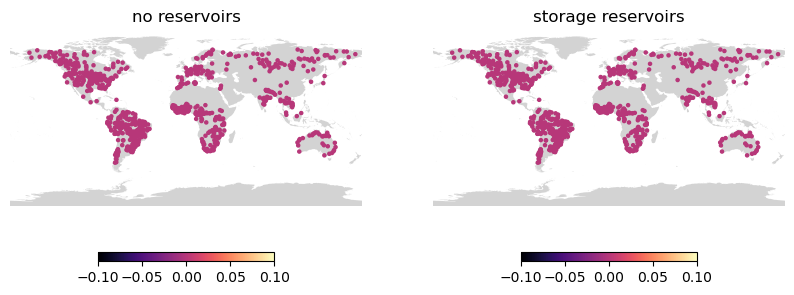

In [85]:
category = 'Lakes_Reservoirs_ID_tables'
var = 'res'

# load map of reservoir ID
res_xr = xr.open_mfdataset(f'{PATH_MAPS}/{category}/*{var}*.nc')[var].compute()

# extract reservoir ID
ids = [int(id) for id in np.unique(res_xr) if (not np.isnan(id))]
ids = [id for id in ids if id >= 0]
print('{0} reservoirs in the study area'.format(len(ids)))

# load table of total reservoir storage
file = list((PATH_MAPS / category).glob('rstor*.txt'))[0]
storage_pd = pd.read_csv(file, sep='\t', header=None, index_col=0).squeeze().astype('int64')
storage_pd.index.name = 'ResID'
storage_pd.name = 'storage'

# create map of reservoir storage
storage = res_xr.copy(deep=True)
for id in ids:
    storage = storage.where(res_xr != id, other=storage_pd.loc[id])
# storage /= 1e6
storage.name = 'storage'
storage.attrs['units'] = 'm3'
storage.attrs['standard_name'] = 'capacity'
storage.attrs['long_name'] = 'reservoir_storage_capacity'

# compute statistics
attr_reservoir = catchment_statistics(storage, masks, statistic=['count', 'sum']).to_pandas()

# rename attributes
attr_reservoir.rename(columns={'storage_count': 'no_reservoirs', 'storage_sum': 'storage_reservoirs'}, inplace=True)

# plot attributes
plot_attributes(attr_reservoir,
                catchments.geometry.x,
                catchments.geometry.y,
                extent=[-180, 180, -90, 90],
                save='maps_reservoirs.jpg')

del res_xr, storage

### Lakes

In [ ]:
category = 'Lakes_Reservoirs_ID_tables'
var = 'lakes'

# load map or lake ID
lakes_xr = xr.open_mfdataset(f'{PATH_MAPS}/{category}/*{var}*.nc')[var].compute()

# extract lake ID
ids = [int(id) for id in np.unique(lakes_xr) if not np.isnan(id)]
ids = [id for id in ids if id >= 0]
print('{0} lakes in the study area'.format(len(ids)))

# load table of lake area
file = list((PATH_MAPS / category).glob('lakearea*.txt'))[0]
lakes_pd = pd.read_csv(file, sep='\t', header=None, index_col=0).squeeze().astype('int64')
lakes_pd.index.name = 'LakeID'
lakes_pd.name = 'area'

# create map of lake area
lakearea = lakes_xr.copy(deep=True)
for id in ids:
    lakearea = lakearea.where(lakes_xr != id, other=lakes_pd.loc[id])
lakearea.name = 'area'
lakearea.attrs['units'] = 'm2'
lakearea.attrs['standard_name'] = 'area'
lakearea.attrs['long_name'] = 'lake_surface_area'

# compute statistics
attr_lake = catchment_statistics(lakearea, masks, statistic=['count', 'sum']).to_pandas()

# rename attributes
attr_lake.rename(columns={'area_count': 'no_lakes', 'area_sum': 'area_lakes'}, inplace=True)

# plot attributes
plot_attributes(attr_lake, 
                catchments.geometry.x, 
                catchments.geometry.y, 
                extent=[-180, 180, -90, 90], 
                save='maps_lakes.jpg'
               )

del lakes_xr, lakearea

### Export

In [ ]:
# concatenate all attributes
attrs = pd.concat((attr_geomorphology,
                  attr_landuse,
                  attr_crops,
                  attr_streams,
                  attr_soils,
                  attr_lai,
                  # attr_demand,
                  attr_reservoir,
                  attr_lake,
                 ), axis=1)
attrs.index.name = 'ID'
attrs.sort_index(axis=0, inplace=True)

print('{0} attributes define the characteristics of {1} catchments'.format(*attrs.shape[::-1]))

# export
attrs.to_csv('attributes_static_maps.csv')

## Model parameters

In [30]:
category = 'GloFASv4.0_calibrated_parameters'
variables = [str(item.name).split('_GloFAS')[0] for item in (PATH_MAPS / category).glob('*.nc')]

# load maps
parameters = {}
for var in variables:
    da = xr.open_mfdataset(f'{PATH_MAPS}/{category}/{var}*.nc')[var].compute()
    if da.dtype == '<m8[ns]':
        da = da.astype(float) / (1e9 * 3600 * 24)
    parameters[var] = da
parameters = xr.Dataset(parameters)
parameters = parameters.where(parameters != -9999, np.nan)

# compute statistics
attr_parameters = catchment_statistics(parameters, masks, statistic=['mean'], weight=pixarea).to_pandas()
attr_parameters.columns = ['_'.join(col.split('_')[:-1]) for col in attr_parameters.columns]

# plot attributes
plot_attributes(attr_parameters,
                catchments.geometry.x,
                catchments.geometry.y,
                ncols=4,
                extent=[-180, 180, -90, 90],
                save='maps_parameters.jpg')

del parameters

attr_parameters.index.name = 'ID'
attr_parameters.sort_index(axis=0, inplace=True)

print('{0} attributes define the model parameters of {1} catchments'.format(*attr_parameters.shape[::-1]))

# export
attr_parameters.to_csv('attributes_model_parameters.csv')